In this google colab notebook, we present a tutorial for using deCS, a in-house tool for automatic cell type annotations for single-cell RNA-seq data. This tutorial is mainly adpated from https://github.com/GuangshengPei/deCS 

In [2]:
%load_ext rpy2.ipython

Install dependency and deCS from github https://github.com/GuangshengPei/deCS ; These could take a while.

In [ ]:
%%R
install.packages("reshape2")
install.packages("ggplot2")
install.packages("Seurat")
install.packages("dplyr")
devtools::install_github("GuangshengPei/deCS")


In [5]:
%%R
library(deCS) 


Load built-in reference annotation panel, we dowhloaded data the annotated single-cell RNA-seq resource BlueprintEncode and DICE MonacoImmue, Human cell landscape. We built the t-statistics and z-score reference panel by using statistical methods described in our previous tissue-specific enrichment analysis work [deTS](https://academic.oup.com/bioinformatics/article/35/19/3842/5368010?login=true)

In [6]:
%%R
# BlueprintEncode_main_t_score
data(BlueprintEncode_main)
# BlueprintEncode_fine_t_score
data(BlueprintEncode_fine)
# DICE_main_t_score
data(DICE_main)
# DICE_fine_t_score
data(DICE_fine)
# MonacoImmune_main_t_score
data(MonacoImmune_main)
# MonacoImmune_fine_t_score
data(MonacoImmune_fine)
# Human_cell_landscape (HCL_z_score)
data(Human_cell_landscape)
# Human_cell_atlas_of_fetal (HCAF_z_score)
data(Human_cell_atlas_of_fetal)

  In addition, we can also load the another cell type marker gene list curated from CellMatch database. [(Shao et al., 2020 )](https://www.sciencedirect.com/science/article/pii/S2589004220300663)



In [7]:
%%R
data(CellMatch)
head(CellMatch_markers)

                       Cell_type Marker_gene
1 1-Cell Stage Cell (Blastomere)       ACCSL
2 1-Cell Stage Cell (Blastomere)      ACVR1B
3 1-Cell Stage Cell (Blastomere)    ARHGEF16
4 1-Cell Stage Cell (Blastomere)       ASF1B
5 1-Cell Stage Cell (Blastomere)     BCL2L10
6 1-Cell Stage Cell (Blastomere)       BLCAP


Input data: a prefiltered PBMC dataset from a Healthy Donor from 10x genomics
https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k

Download Input data

In [8]:
!mkdir data

In [9]:
%%R
curl::curl_download("https://github.com/GuangshengPei/deCS/raw/main/Example_data/1.1.PBMC/hg19/barcodes.tsv", "data/barcodes.tsv")
curl::curl_download("https://github.com/GuangshengPei/deCS/raw/main/Example_data/1.1.PBMC/hg19/genes.tsv", "data/genes.tsv")
curl::curl_download("https://github.com/GuangshengPei/deCS/raw/main/Example_data/1.1.PBMC/hg19/matrix.mtx", "data/matrix.mtx")

In [10]:
%%R
library(Seurat)
library(dplyr)
pbmc.data <- Read10X(data.dir = "data", gene.column=2)

R[write to console]: Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

R[write to console]: Attaching SeuratObject

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Initialize the Seurat object with the raw data, then conduct standard normalization.

In [ ]:
%%R
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc <- pbmc %>%
  NormalizeData() %>%
  FindVariableFeatures() %>%
  ScaleData() %>%
  RunPCA() 

In [12]:
%%R
pbmc

An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 2000 variable features)
 1 dimensional reduction calculated: pca


Standard cell clustering analysis.

In [ ]:
%%R
pbmc <- FindNeighbors(pbmc, dims = 1:10) 
pbmc <- FindClusters(pbmc, resolution = 0.5)
pbmc <- RunUMAP(pbmc, dims = 1:10) 

Identify cluster specific expressed genes.

In [14]:
%%R
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
top10 <- pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)
pbmc_top10_markers_list = pbmc.markers[which(pbmc.markers$gene %in% top10$gene),] 

R[write to console]: Calculating cluster 0

R[write to console]: For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=05s  


R[write to console]: Calculating cluster 1



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=10s  


R[write to console]: Calculating cluster 2



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=06s  


R[write to console]: Calculating cluster 3



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=05s  


R[write to console]: Calculating cluster 4



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=05s  


R[write to console]: Calculating cluster 5



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=14s  


R[write to console]: Calculating cluster 6



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=12s  


R[write to console]: Calculating cluster 7



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=14s  


R[write to console]: Calculating cluster 8



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=09s  


Union of marker genes and z-score calculation, we scale the expression by gene across cells


In [15]:
%%R
pbmc_cluster_average = AverageExpression(pbmc)[[1]]
pbmc_cluster_marker_average = pbmc_cluster_average[which(rownames(pbmc_cluster_average) %in% top10$gene), ]
pbmc_cluster_marker_z_score = t(scale(t(pbmc_cluster_marker_average)))

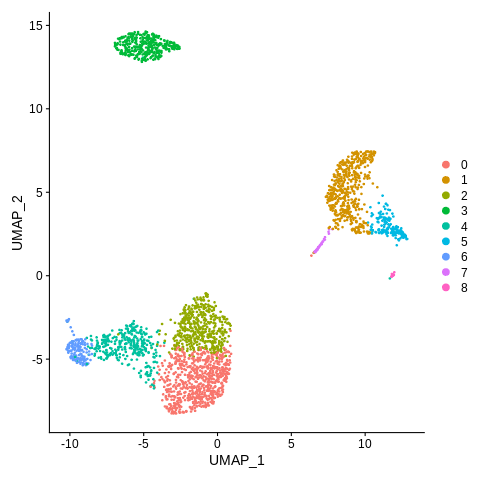

In [17]:
%%R
DimPlot(pbmc)

deCS correlation analysis for expression profiles

R[write to console]: Loading required package: ggplot2



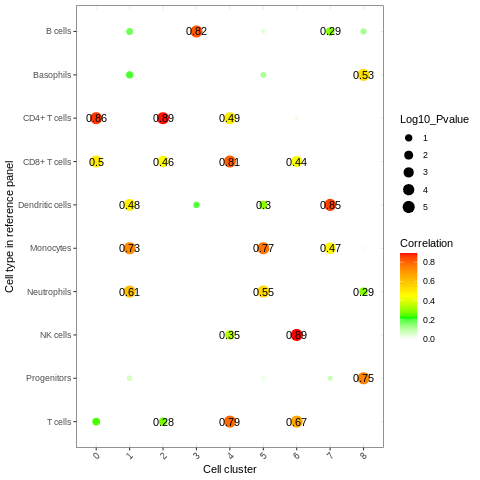

In [18]:
%%R
head(pbmc_cluster_marker_z_score)
pbmc_deCS_cor_panel_A <- deCS.correlation(pbmc_cluster_marker_z_score, MonacoImmune_main_t_score)


deCS Fisher's exact test for list of genes


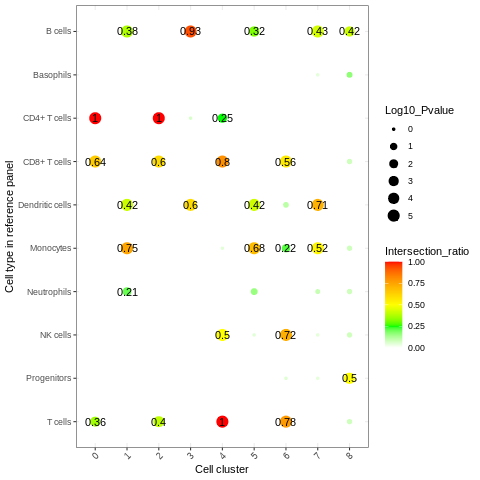

In [19]:
%%R
head(pbmc_top10_markers_list, 20)
pbmc_deCS_FET_panel_A <- deCS.fisher(pbmc_top10_markers_list, MonacoImmune_main_t_score)


deCS Fisher's exact test for list of genes in CellMatch panel

In [ ]:
%%R
pbmc_deCS_FET_CellMatch <- deCS.fisher(pbmc_top10_markers_list, CellMatch_markers, type = "list", p.adjust.methods = "bonferroni", p_threshold = 1e-3, cell_type_threshold = 0.05)
